In [1]:
import os
import numpy as np
import pandas as pd
import re
import geopandas as gpd
import pyarrow as pa
import pyarrow.parquet as pq
import json

from sklearn.neighbors import KernelDensity
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
# from matplotlib import colormaps
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Import the module for creating colorbars

# Paths
BASE_PATH = 'D:/KIMoDIs/global-groundwater-models-main'
DATA_PATH = os.path.join(BASE_PATH, 'data')
RESULT_PATH = os.path.join(BASE_PATH, 'results')
FIGURES_PATH = 'J:/Berlin/B22-FISHy/PROJEKTE/KIMoDIs/Konferenzen/FH-DGGV_2024/plots_fhdggv'
SHARE_PATH = 'J:/Berlin/B22-FISHy/NUTZER/Kunz.S'

VERSION = '10_Epochs'

In [2]:
FONT_SIZE = 20
# Plotting settings
plt.rcParams.update({
        "font.size": FONT_SIZE,
        "xtick.labelsize": FONT_SIZE-2,
        "ytick.labelsize": FONT_SIZE-2,
        
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold',
        
        'lines.markersize': 3,
        
        "legend.frameon": True,
        "legend.fontsize": FONT_SIZE-2,
        "legend.title_fontsize": FONT_SIZE-2,
        
        "savefig.dpi": 300,     # higher resolution output.
        "savefig.bbox": 'tight'})

In [3]:
## TFT
MODEL_TYPE_ls = ['tft_full', 'tft_dyn', 'tft_full_interpol']
imp_dict = {}

for MODEL_TYPE in MODEL_TYPE_ls: 
    imp_ls = []
    
    folder = os.path.join(BASE_PATH, 
                       'results', 
                       'interpretation',
                       'tft',
                       f'{MODEL_TYPE}',
                       f'{MODEL_TYPE}_4096_{VERSION}')
    
    init = [name for name in os.listdir(folder)]
    
    for i in init: 
        with open(os.path.join(folder, i)) as f:
            _imp = json.load(f)
            _imp = pd.DataFrame(_imp)
            _i = re.sub('(tft_)(version_.*)(_variable_importance_.+)(.json)', '\\2',i)
            _imp['init'] = _i
            _imp['model_type'] = MODEL_TYPE
        
            imp_ls.append(_imp)
            
    imp_dict[MODEL_TYPE] = imp_ls

In [4]:
imp_df = pd.concat(
    [pd.concat([pd.DataFrame(imp_dict['tft_full'][i]) for i in range(len(imp_dict['tft_full']))], 
                               ignore_index=False),
     pd.concat([pd.DataFrame(imp_dict['tft_dyn'][i]) for i in range(len(imp_dict['tft_dyn']))], 
                               ignore_index=False),
     pd.concat([pd.DataFrame(imp_dict['tft_full_interpol'][i]) for i in range(len(imp_dict['tft_full_interpol']))], 
                               ignore_index=False)]
)

imp_df = imp_df.reset_index()
imp_df = imp_df.rename(columns={'index':'feature', 
                                'static_variables':'imp_static',
                                'encoder_variables':'imp_encoder',
                                'decoder_variables':'imp_decoder'})

In [5]:
STATICS = {
    'gwl_scale': 'Standard dev. groundwater level',
    'twi': 'Topographical Wetness Index (TWI)',
    'aquifer_type': 'Aquifer type',
    'landform_sha10km': 'Landform Shannon Index',
    'elevation': 'Elevation',
    'hyraum_gr': 'Hydrogeological division',
    'gw_recharge': 'Groundwater recharge rate',
    'gwl_center': 'Mean groundwater level',
    'permeability_coef': 'Permeability',
    'soil_texture': 'Soil texture',
    'eumohp_sd1': 'EUMOHP SD1',
    'land_cover': 'Land cover',
    'eumohp_lp1': 'EUMOHP LP1',
    'eumohp_dsd1': 'EUMOHP DSD1'
 }

TEMPORALS = {
    'precip': 'Precipitation',
    'humid': 'Humidity',
    'temp': 'Temperature',
    'sin_temp': 'Sinus temperature',
    'gwl': 'Groundwater level',
    'day': 'Day of the year',
    'lai': 'Leaf Area Index',
    'day_sin': 'Sinus day',
    'day_cos': 'Cosinus day'
}

In [6]:
VARIABLE_TYPE_ls = ['imp_static', 'imp_encoder', 'imp_decoder']
[item for item in VARIABLE_TYPE_ls if item !='imp_static']

['imp_encoder', 'imp_decoder']

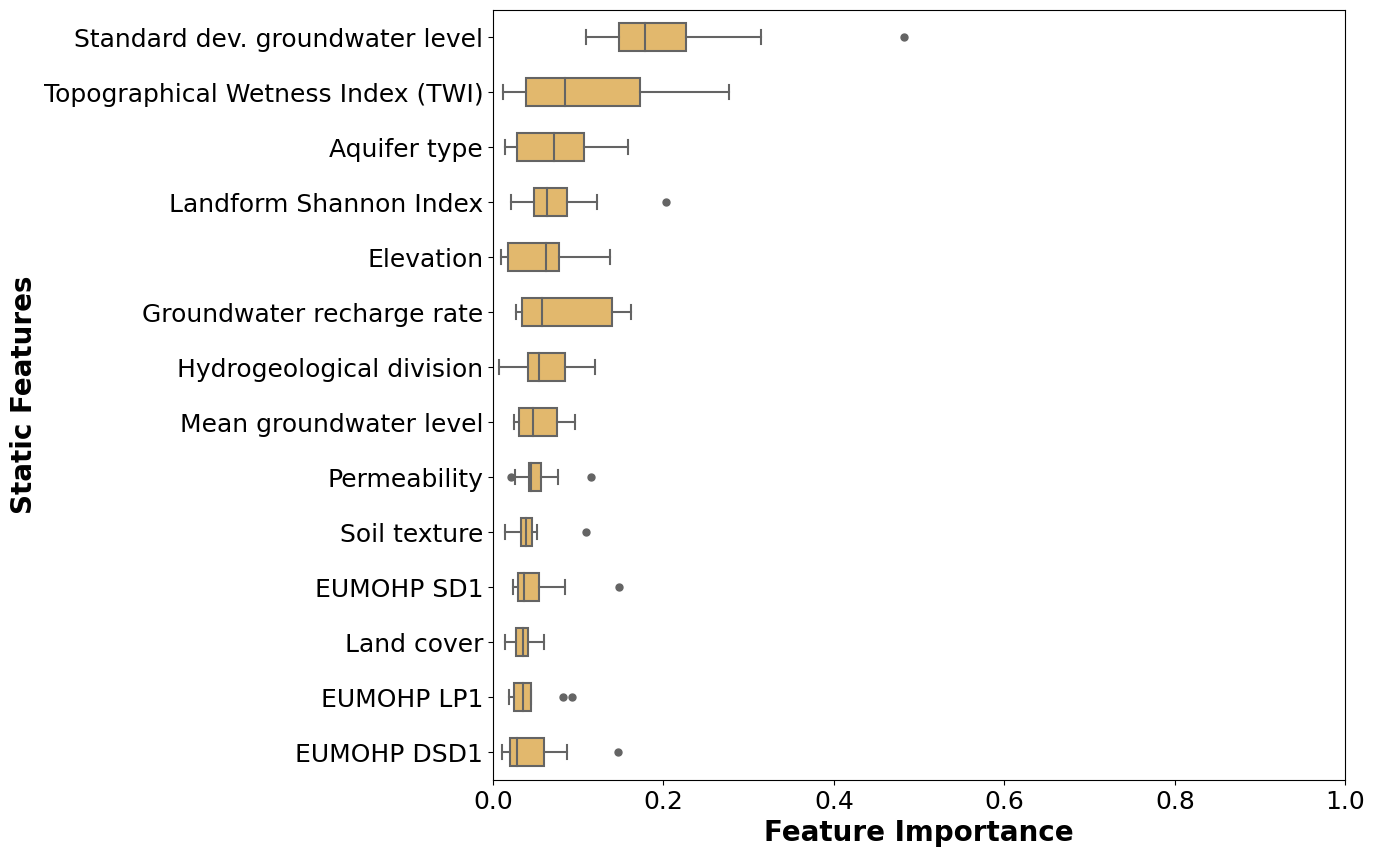

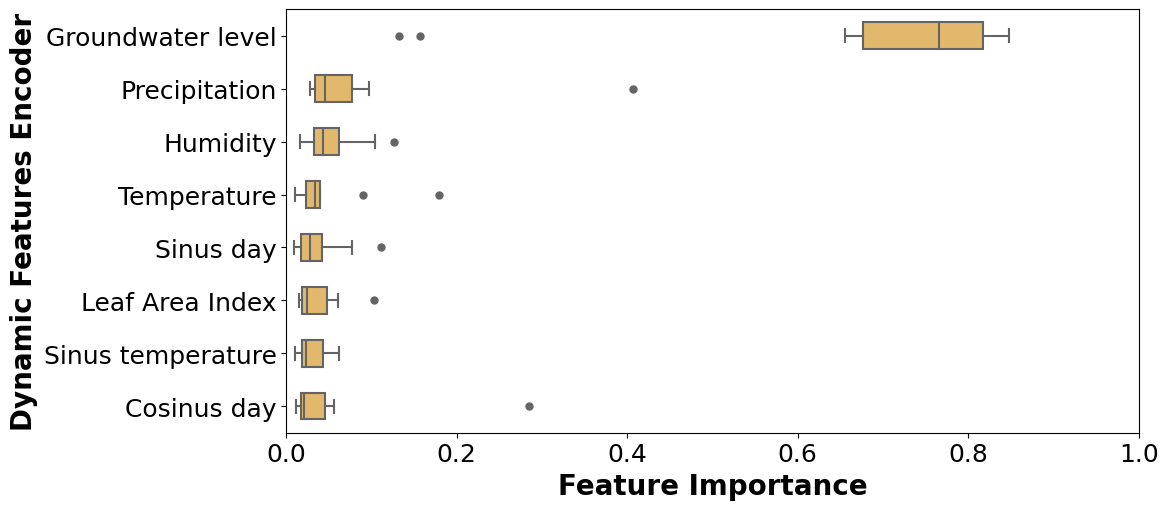

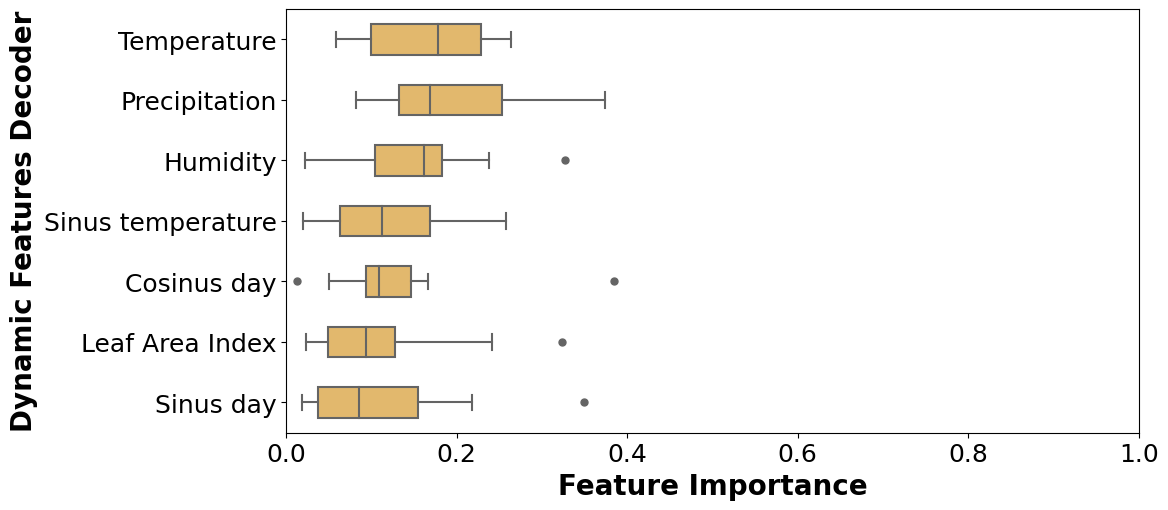

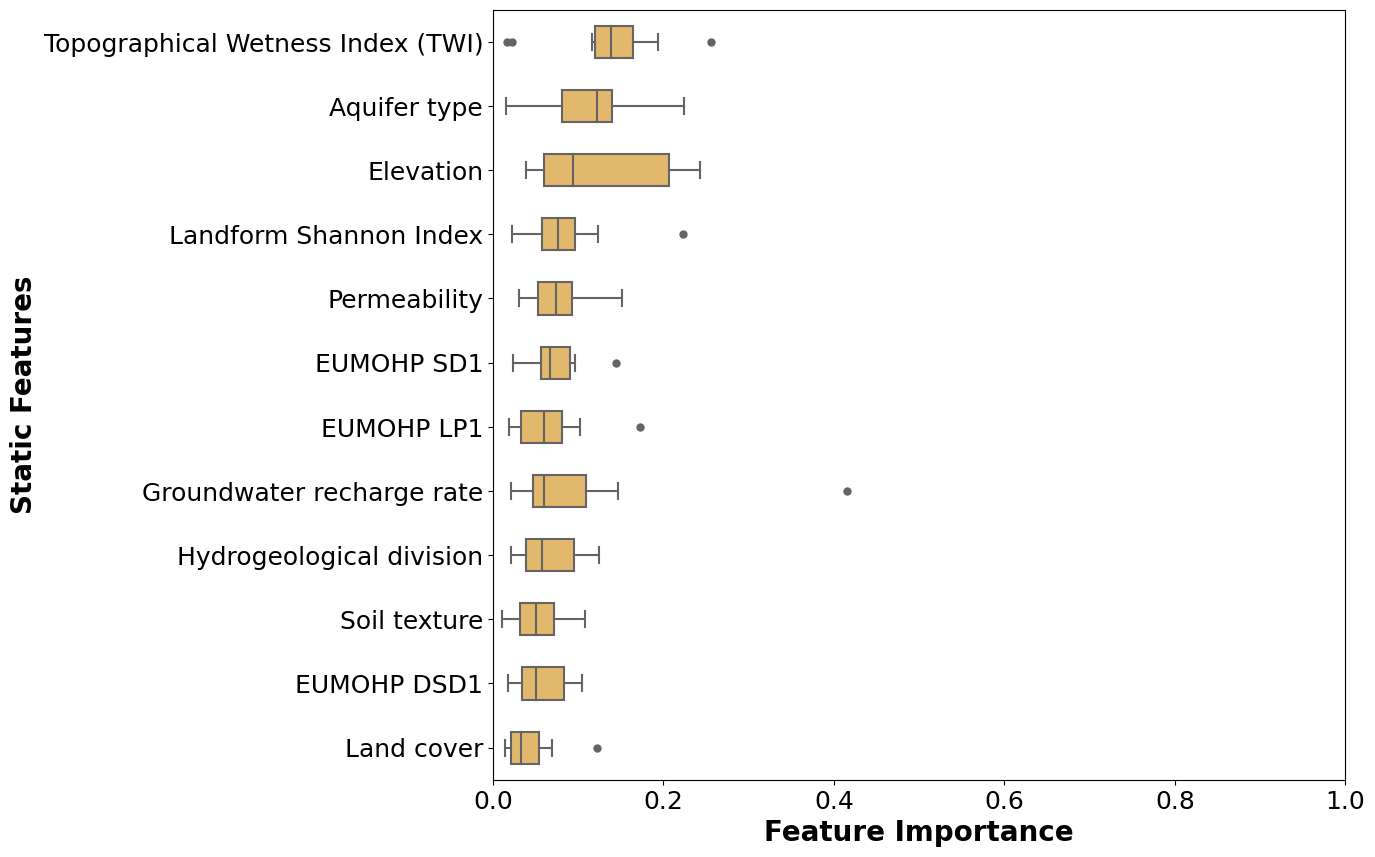

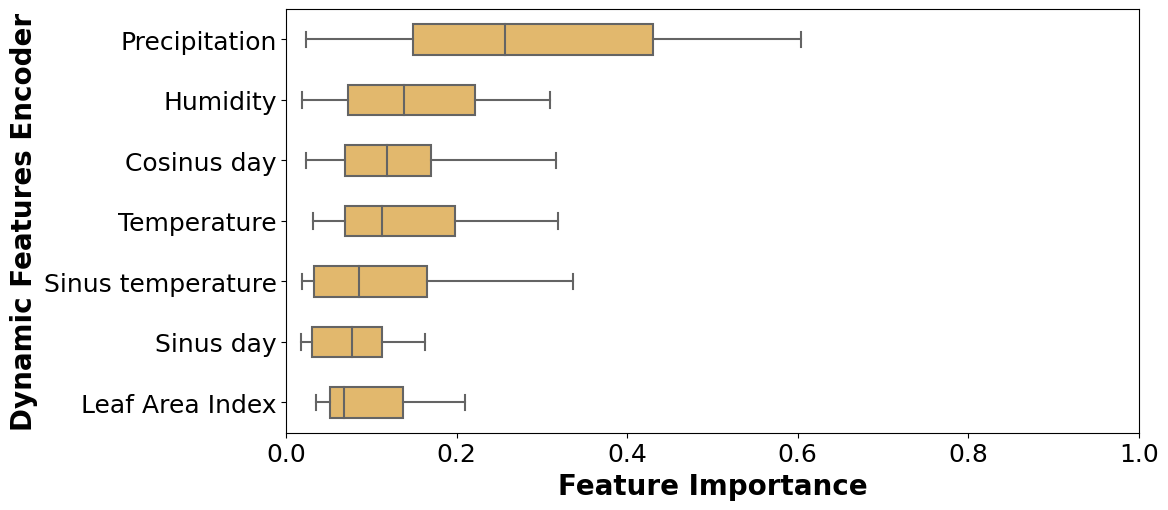

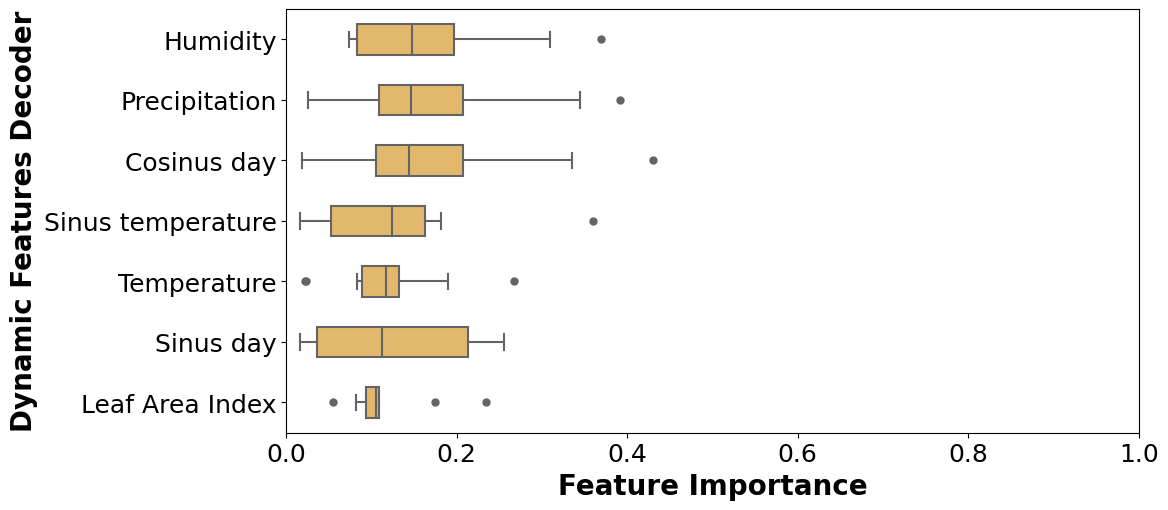

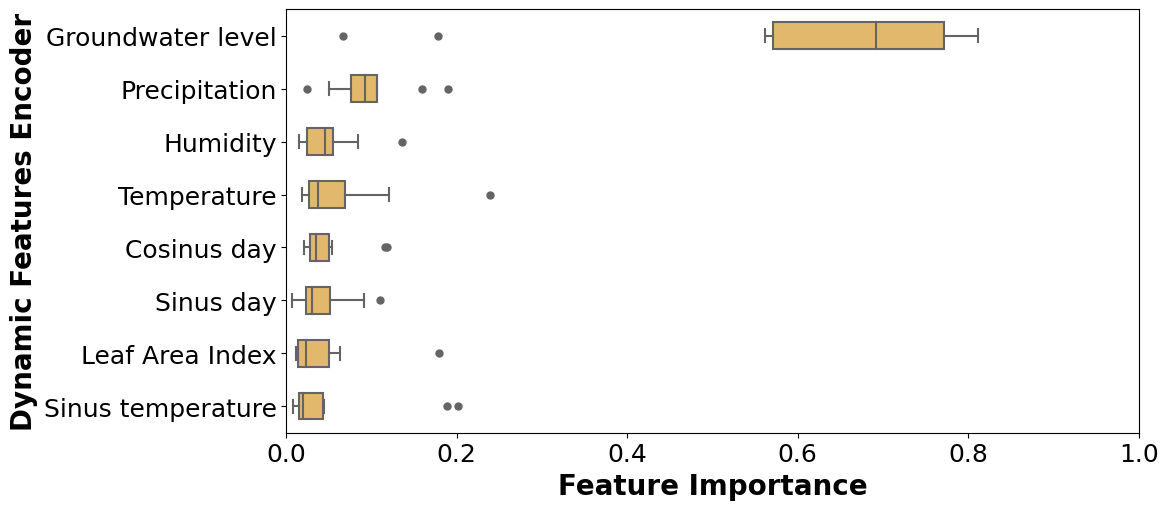

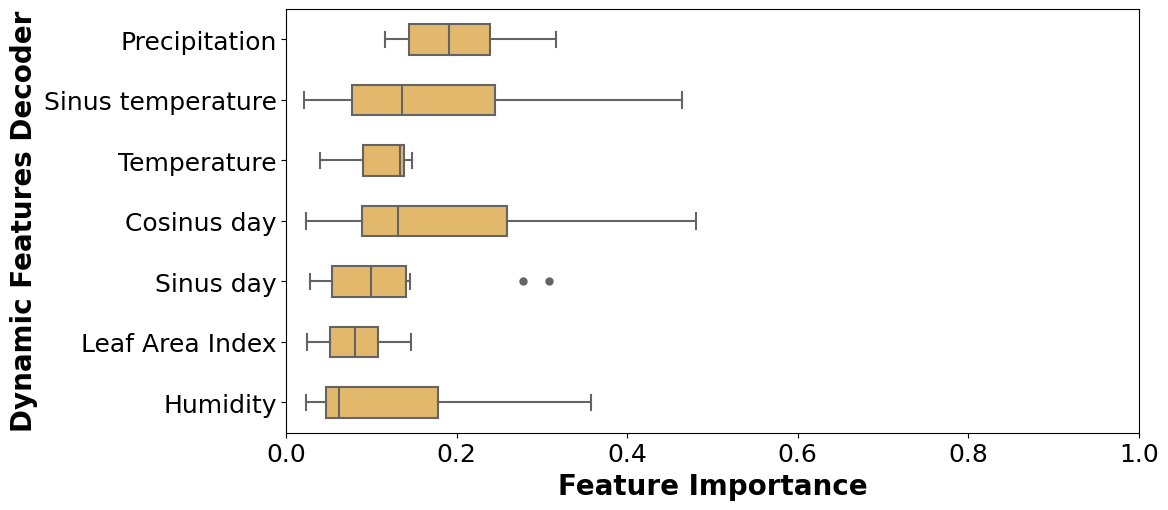

In [9]:
# Assuming imp_subset is your DataFrame with 'init' and 'feature' columns
VARIABLE_TYPE_ls = ['imp_static', 'imp_encoder', 'imp_decoder']
MODEL_TYPE_ls = ['tft_full', 'tft_full_interpol', 'tft_dyn']

for MODEL_TYPE in MODEL_TYPE_ls:
    
    imp_subset = imp_df[(imp_df['model_type']==MODEL_TYPE)]
    imp_subset = pd.melt(imp_subset, 
                         id_vars=['feature', 'init', 'model_type'],
                         var_name='feature_type',
                         value_name='importance')
    
    if MODEL_TYPE == 'tft_dyn':
        VARIABLE_TYPE_ls = [item for item in VARIABLE_TYPE_ls if item !='imp_static']
    
    for VARIABLE_TYPE in VARIABLE_TYPE_ls:
        
        if VARIABLE_TYPE == 'imp_static':
            fig, ax = plt.subplots(1, figsize=(11, 10))
        else: 
            fig, ax = plt.subplots(1, figsize=(11, 5.5))

        _imp_subset = imp_subset[(imp_subset['feature_type']==VARIABLE_TYPE) & (~imp_subset['importance'].isna())]
        
        # Order y column
        order = _imp_subset.groupby('feature')['importance'].median().sort_values(ascending=False).index    
        
        # Use seaborn's boxplot to create horizontal boxplot

        sns.boxplot(x='importance', 
            y='feature',  
            data=_imp_subset, 
            orient='h', 
            color='#F5BE5A',
            order=order,
            ax=ax,
            width=0.5, 
            flierprops=dict(marker='o', markersize=5))
        ax.set_xlim([0, 1])
        ax.set_yticklabels([STATICS.get(label) if VARIABLE_TYPE == 'imp_static' else TEMPORALS.get(label) for label in order])
        ax.set_xlabel('Feature Importance', fontweight='bold')
        ax.set_ylabel(
              'Static Features' if VARIABLE_TYPE == 'imp_static'else 
              'Dynamic Features Encoder' if VARIABLE_TYPE == 'imp_encoder' else 
              'Dynamic Features Decoder', fontweight='bold')
        fig.savefig(os.path.join(SHARE_PATH, 
                                 'global_mod_paper',
                                 'figures',
                                 f'{MODEL_TYPE}_feature_importance_{VARIABLE_TYPE}.png'))
        plt.show()